In [1]:

import pandas as pd

# Load CSV data from 'data' directory
data_file = 'data/API_SP.POP.TOTL_DS2_en_csv_v2_76253.csv'
metadata_country = 'data/Metadata_Country_API_SP.POP.TOTL_DS2_en_csv_v2_76253.csv'
metadata_indicator = 'data/Metadata_Indicator_API_SP.POP.TOTL_DS2_en_csv_v2_76253.csv'

data = pd.read_csv(data_file, skiprows=4)
meta_country = pd.read_csv(metadata_country)
meta_indicator = pd.read_csv(metadata_indicator)


In [2]:

import matplotlib.pyplot as plt

# Whenever saving figures
plt.savefig('results/your_figure_name.png', dpi=300, bbox_inches='tight')


<Figure size 640x480 with 0 Axes>

In [3]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)

In [4]:


fractional_losses = np.array([
    0.125,  # Plague of Justinian (541 CE)
    0.1875, # Black Death (1346 CE)
    0.0008, # 3rd Cholera (1852 CE)
    0.0002, # 5th Cholera (1881 CE)
    0.0007, # H2N2 Flu (1889 CE)
    0.00045, # 6th Cholera (1910 CE)
    0.0278, # H1N1 Flu (1918 CE)
    0.0007, # H2N2 Flu (1956 CE)
    0.0003, # H3N2 Flu (1968 CE)
    0.0073, # HIV/AIDS (1981-present)
    0.000085, # H1N1 Flu (2009 CE)
    0.00025  # COVID-19 (2019-present)
])

J_mean = np.mean(fractional_losses)
J_std = np.std(fractional_losses)

J_mean, J_std

(np.float64(0.029257083333333333), np.float64(0.058692474761049135))

In [5]:
# To calculate the beta value
file_path = "data/API_SP.POP.TOTL_DS2_en_csv_v2_76253.csv"
population_data = pd.read_csv(file_path, skiprows=4)

world_population = population_data[population_data['Country Name'] == 'World']

world_population = world_population.iloc[:, 4:].T 
world_population.columns = ['Population']
world_population.index = pd.to_numeric(world_population.index, errors='coerce')
world_population = world_population.dropna()
world_population['Growth Rate'] = world_population['Population'].pct_change()
beta = world_population['Growth Rate'].std()

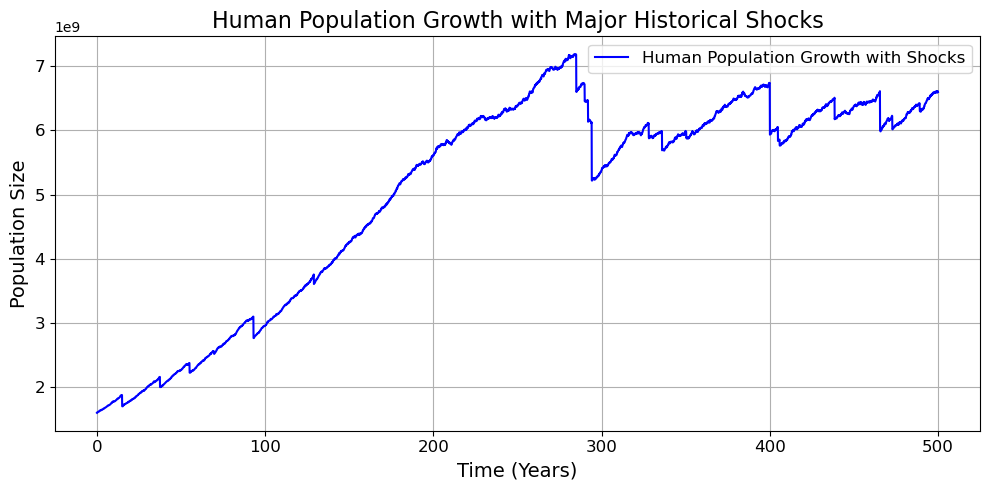

In [6]:



# Parameters
K = 8e9         # Carrying capacity for human population (8 billion)
r = 0.015   # Intrinsic growth rate for humans 
beta = 0.00363  # Diffusion coefficient (calculated above)
lambda_ = 0.0667 # Poisson process rate (1 pandemic per 15 years)
J_mean = 0.0293 # Mean fractional drop due to major events (calculated above)
J_std = 0.0587  # Standard deviation of fractional drop (also calculated above)
T = 500         # Total simulation time in years
dt = 0.1        # Time step size
N_steps = int(T / dt)  # Number of time steps

# Time vector
t = np.linspace(0, T, N_steps + 1)

# Initialize population
N = np.zeros(N_steps + 1)
N[0] = 1.6e9  # Human population in the early 1900s (like before WW1)

# Simulating the stochastic process
for n in range(N_steps):
    eta = np.random.randn()  # Standard normal variable
    dW = np.sqrt(dt) * eta   # Wiener process increment
    dN = np.random.poisson(lambda_ * dt)  # Poisson process increment
    J_t = max(0, np.random.normal(J_mean, J_std))
    
    # Apply the stochastic logistic equation
    dP = r * N[n] * (1 - N[n] / K) * dt + beta * N[n] * dW - J_t * N[n] * dN
    N[n+1] = max(N[n] + dP, 0)



plt.figure(figsize=(10, 5))
plt.plot(t, N, label='Human Population Growth with Shocks', color='b')
plt.xlabel('Time (Years)', fontsize=14)
plt.ylabel('Population Size', fontsize=14)
plt.title('Human Population Growth with Major Historical Shocks', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

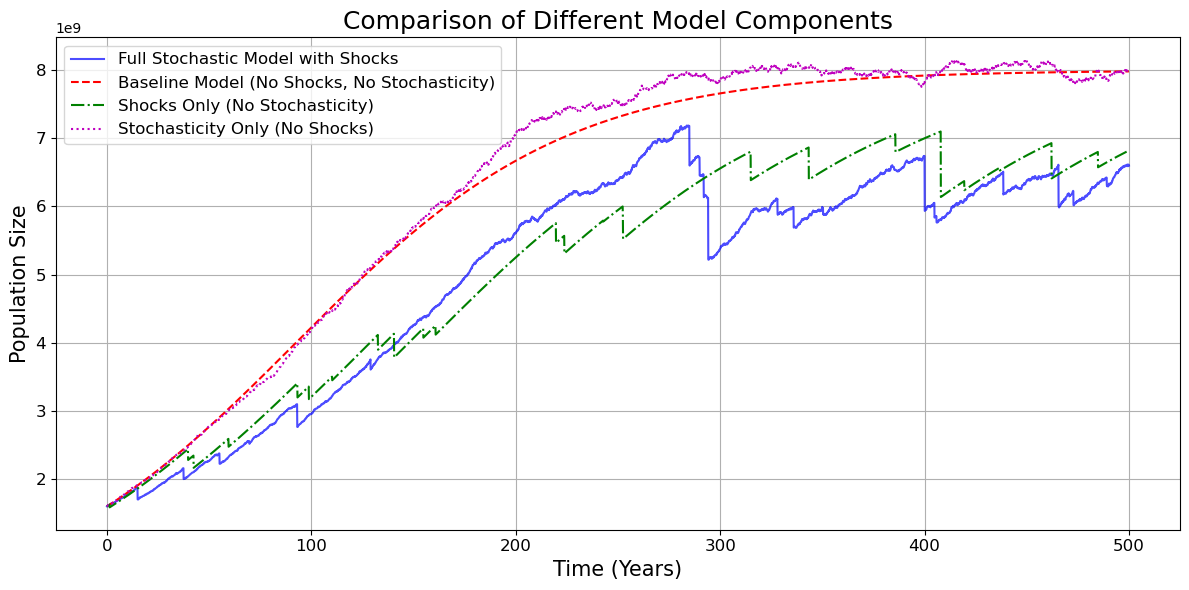

In [7]:
# Baseline model without shocks and stochasticity
N_baseline = np.zeros(N_steps + 1)
N_baseline[0] = 1.6e9  # Initial population

# Model with shocks but no stochasticity
N_shocks_only = np.zeros(N_steps + 1)
N_shocks_only[0] = 1.6e9  # Initial population

# Model with stochasticity but no shocks
N_stochastic_only = np.zeros(N_steps + 1)
N_stochastic_only[0] = 1.6e9  # Initial population


for n in range(N_steps):
    # Generate random variables once for consistent comparison
    eta = np.random.randn()  # Standard normal variable
    dW = np.sqrt(dt) * eta   # Wiener process increment
    dN = np.random.poisson(lambda_ * dt)  # Poisson process increment
    J_t = max(0, np.random.normal(J_mean, J_std))
    
    # Apply the deterministic logistic equation (baseline)
    dP_baseline = r * N_baseline[n] * (1 - N_baseline[n] / K) * dt
    N_baseline[n+1] = max(N_baseline[n] + dP_baseline, 0)
    
    # Apply logistic equation with shocks only (no stochasticity)
    dP_shocks_only = r * N_shocks_only[n] * (1 - N_shocks_only[n] / K) * dt - J_t * N_shocks_only[n] * dN
    N_shocks_only[n+1] = max(N_shocks_only[n] + dP_shocks_only, 0)
    
    # Apply logistic equation with stochasticity only (no shocks)
    dP_stochastic_only = r * N_stochastic_only[n] * (1 - N_stochastic_only[n] / K) * dt + beta * N_stochastic_only[n] * dW
    N_stochastic_only[n+1] = max(N_stochastic_only[n] + dP_stochastic_only, 0)


plt.figure(figsize=(12, 6))
plt.plot(t, N, label='Full Stochastic Model with Shocks', color='b', alpha=0.7)
plt.plot(t, N_baseline, label='Baseline Model (No Shocks, No Stochasticity)', color='r', linestyle='--')
plt.plot(t, N_shocks_only, label='Shocks Only (No Stochasticity)', color='g', linestyle='-.')
plt.plot(t, N_stochastic_only, label='Stochasticity Only (No Shocks)', color='m', linestyle=':')
plt.xlabel('Time (Years)', fontsize=15)
plt.ylabel('Population Size', fontsize=15)
plt.title('Comparison of Different Model Components', fontsize=18)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

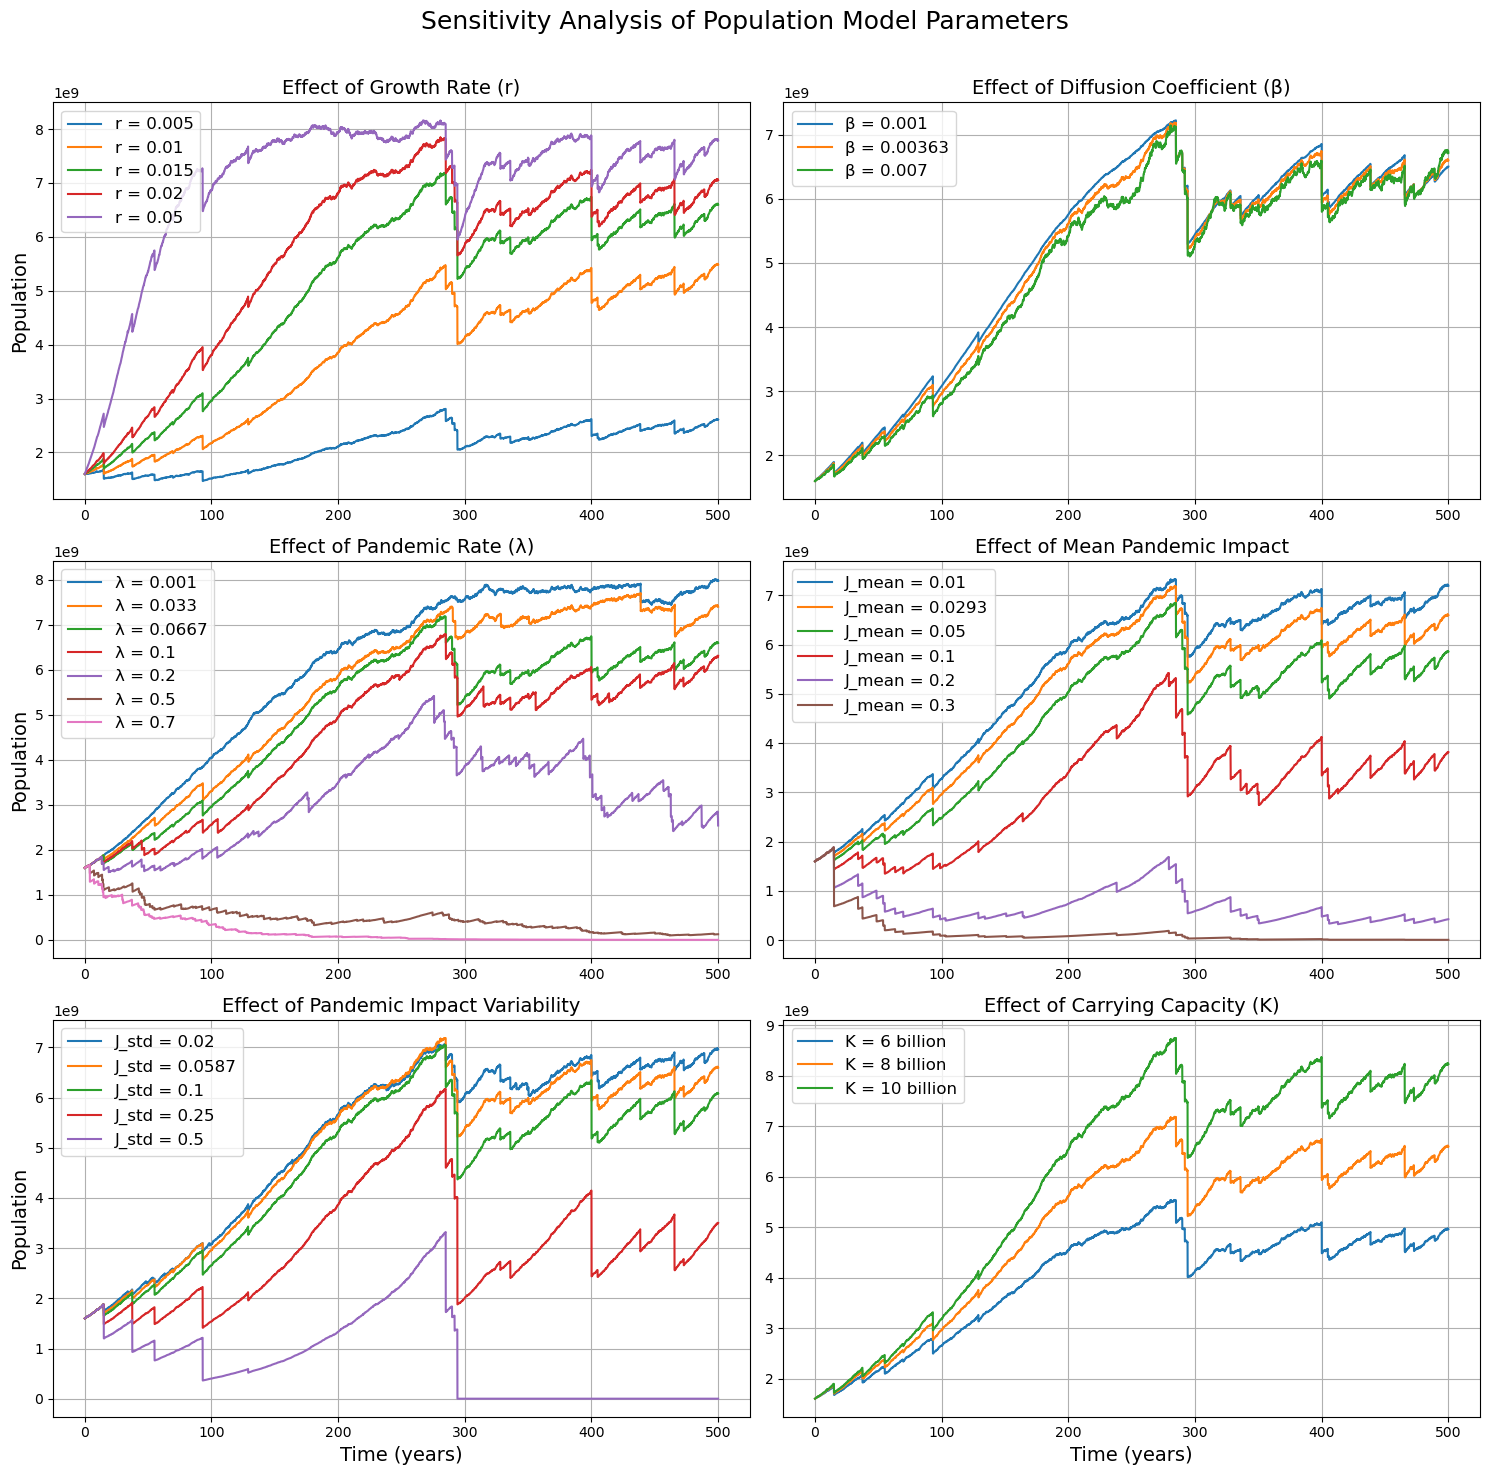

In [8]:
# Base parameters
K_base = 8e9         # Carrying capacity
r_base = 0.015       # Intrinsic growth rate
beta_base = 0.00363  # Diffusion coefficient
lambda_base = 0.0667 # Pandemic rate (1 per 15 years)
J_mean_base = 0.0293 # Mean fractional drop
J_std_base = 0.0587  # Standard deviation of fractional drop
T = 500              # Simulation time in years
dt = 0.1             # Time step
N_steps = int(T / dt)
initial_pop = 1.6e9  # Initial population

# Time vector
t = np.linspace(0, T, N_steps + 1)

# Function to run simulation with given parameters
def run_simulation(r, beta, lambda_, J_mean, J_std, K):
    N = np.zeros(N_steps + 1)
    N[0] = initial_pop
    
    np.random.seed(42)  # For reproducibility
    
    for n in range(N_steps):
        eta = np.random.randn()
        dW = np.sqrt(dt) * eta
        dN = np.random.poisson(lambda_ * dt)
        J_t = max(0, np.random.normal(J_mean, J_std))
        
        dP = r * N[n] * (1 - N[n] / K) * dt + beta * N[n] * dW - J_t * N[n] * dN
        N[n+1] = max(N[n] + dP, 0)
    
    return N

# Create subplots for each parameter
fig, axs = plt.subplots(3, 2, figsize=(15, 15))
fig.suptitle('Sensitivity Analysis of Population Model Parameters', fontsize=18)

# 1. Varying intrinsic growth rate (r)
r_values = [0.005, 0.01, 0.015, 0.02, 0.05]
for r in r_values:
    N = run_simulation(r, beta_base, lambda_base, J_mean_base, J_std_base, K_base)
    axs[0, 0].plot(t, N, label=f'r = {r}')
axs[0, 0].set_title('Effect of Growth Rate (r)', fontsize=14)
axs[0, 0].set_ylabel('Population', fontsize=14)
axs[0, 0].legend(fontsize=12)
axs[0, 0].tick_params(labelsize=10)
axs[0, 0].grid(True)

# 2. Varying diffusion coefficient (beta)
beta_values = [0.001, 0.00363, 0.007]
for beta in beta_values:
    N = run_simulation(r_base, beta, lambda_base, J_mean_base, J_std_base, K_base)
    axs[0, 1].plot(t, N, label=f'β = {beta}')
axs[0, 1].set_title('Effect of Diffusion Coefficient (β)', fontsize=14)
axs[0, 1].legend(fontsize=12)
axs[0, 1].tick_params(labelsize=10)
axs[0, 1].grid(True)

# 3. Varying pandemic rate (lambda)
lambda_values = [0.001, 0.033, 0.0667, 0.1, 0.2, 0.5, 0.7]
for lambda_ in lambda_values:
    N = run_simulation(r_base, beta_base, lambda_, J_mean_base, J_std_base, K_base)
    axs[1, 0].plot(t, N, label=f'λ = {lambda_}')
axs[1, 0].set_title('Effect of Pandemic Rate (λ)', fontsize=14)
axs[1, 0].set_ylabel('Population', fontsize=14)
axs[1, 0].legend(fontsize=12)
axs[1, 0].tick_params(labelsize=10)
axs[1, 0].grid(True)

# 4. Varying mean pandemic impact (J_mean)
J_mean_values = [0.01, 0.0293, 0.05, 0.1, 0.2, 0.3]
for J_mean in J_mean_values:
    N = run_simulation(r_base, beta_base, lambda_base, J_mean, J_std_base, K_base)
    axs[1, 1].plot(t, N, label=f'J_mean = {J_mean}')
axs[1, 1].set_title('Effect of Mean Pandemic Impact', fontsize=14)
axs[1, 1].legend(fontsize=12)
axs[1, 1].tick_params(labelsize=10)
axs[1, 1].grid(True)

# 5. Varying pandemic impact variability (J_std)
J_std_values = [0.02, 0.0587, 0.1, 0.25, 0.5]
for J_std in J_std_values:
    N = run_simulation(r_base, beta_base, lambda_base, J_mean_base, J_std, K_base)
    axs[2, 0].plot(t, N, label=f'J_std = {J_std}')
axs[2, 0].set_title('Effect of Pandemic Impact Variability', fontsize=14)
axs[2, 0].set_xlabel('Time (years)', fontsize=14)
axs[2, 0].set_ylabel('Population', fontsize=14)
axs[2, 0].legend(fontsize=12)
axs[2, 0].tick_params(labelsize=10)
axs[2, 0].grid(True)

# 6. Varying carrying capacity (K)
K_values = [6e9, 8e9, 10e9]
for K in K_values:
    N = run_simulation(r_base, beta_base, lambda_base, J_mean_base, J_std_base, K)
    axs[2, 1].plot(t, N, label=f'K = {K/1e9:.0f} billion')
axs[2, 1].set_title('Effect of Carrying Capacity (K)', fontsize=14)
axs[2, 1].set_xlabel('Time (years)', fontsize=14)
axs[2, 1].legend(fontsize=12)
axs[2, 1].tick_params(labelsize=10)
axs[2, 1].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

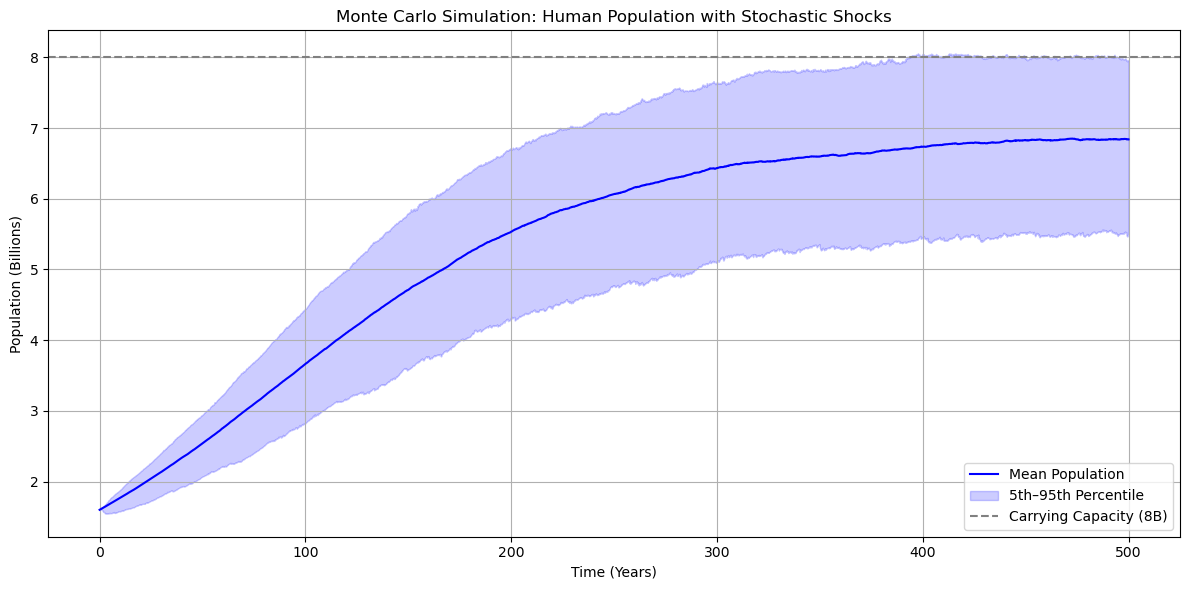

In [ ]:

# Parameters based on the report
r = 0.015  # intrinsic growth rate
K = 8e9  # carrying capacity
beta = 0.00363  # diffusion coefficient (environmental noise)
lambda_ = 1 / 15  # rate of Poisson shocks (~1 every 15 years)
J_mean = 0.0293  # mean fractional population drop
J_std = 0.0587  # std dev of drop
T = 500  # simulation time in years
dt = 0.1  # time step
N_steps = int(T / dt)
N0 = 1.6e9  # initial population
simulations = 1000  # number of Monte Carlo simulations

# Time array
time = np.linspace(0, T, N_steps + 1)

# Storage for all simulations
trajectories = np.zeros((simulations, N_steps + 1))

# Run simulations
for sim in range(simulations):
    N = np.zeros(N_steps + 1)
    N[0] = N0
    for t in range(N_steps):
        dW = np.random.normal(0, np.sqrt(dt))
        dN_poisson = np.random.poisson(lambda_ * dt)
        J_t = np.random.normal(J_mean, J_std) if dN_poisson > 0 else 0
        N[t + 1] = N[t] + r * N[t] * (1 - N[t] / K) * dt + beta * N[t] * dW - J_t * N[t] * dN_poisson
        N[t + 1] = max(N[t + 1], 0)  # population can't go negative
    trajectories[sim] = N

# Compute mean and confidence intervals
mean_trajectory = trajectories.mean(axis=0)
percentile_5 = np.percentile(trajectories, 5, axis=0)
percentile_95 = np.percentile(trajectories, 95, axis=0)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(time, mean_trajectory / 1e9, label="Mean Population", color="blue")
plt.fill_between(time, percentile_5 / 1e9, percentile_95 / 1e9, color="blue", alpha=0.2, label="5th–95th Percentile")
plt.axhline(K / 1e9, color='gray', linestyle='--', label="Carrying Capacity (8B)")
plt.xlabel("Time (Years)")
plt.ylabel("Population (Billions)")
plt.title("Monte Carlo Simulation: Human Population with Stochastic Shocks")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
